1. Setup and Loading Data

In [3]:
#pip install tensorflow tensorflow gpu opencv python patplotlib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir('/content/drive/MyDrive/Datasets')

In [6]:
pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohappyeyeballs                 2.3.4
aiohttp                          3.10.1
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.13
albumentations                   1.4.13
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.8.5.0.32.23
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread               

In [7]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [8]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
import cv2
import imghdr

In [10]:
data_dir='data'

In [11]:
os.listdir(os.path.join(data_dir,))

['Happy', 'Sad']

In [12]:
image_exts=['jpeg','jpg','bmp','png']

In [13]:
image_exts[0]

'jpeg'

In [14]:
#Remove the unvalid types's images
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path=os.path.join(data_dir,image_class,image)
        try:
          img=cv2.imread(image_path)
          tip=imghdr.what(image_path)
          if tip not in image_exts:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Load Data

In [15]:
data=tf.keras.utils.image_dataset_from_directory('data')

Found 170 files belonging to 2 classes.


In [16]:
data_iteration=data.as_numpy_iterator()

In [17]:
batch=data_iteration.next()

In [18]:
batch[1]

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1], dtype=int32)

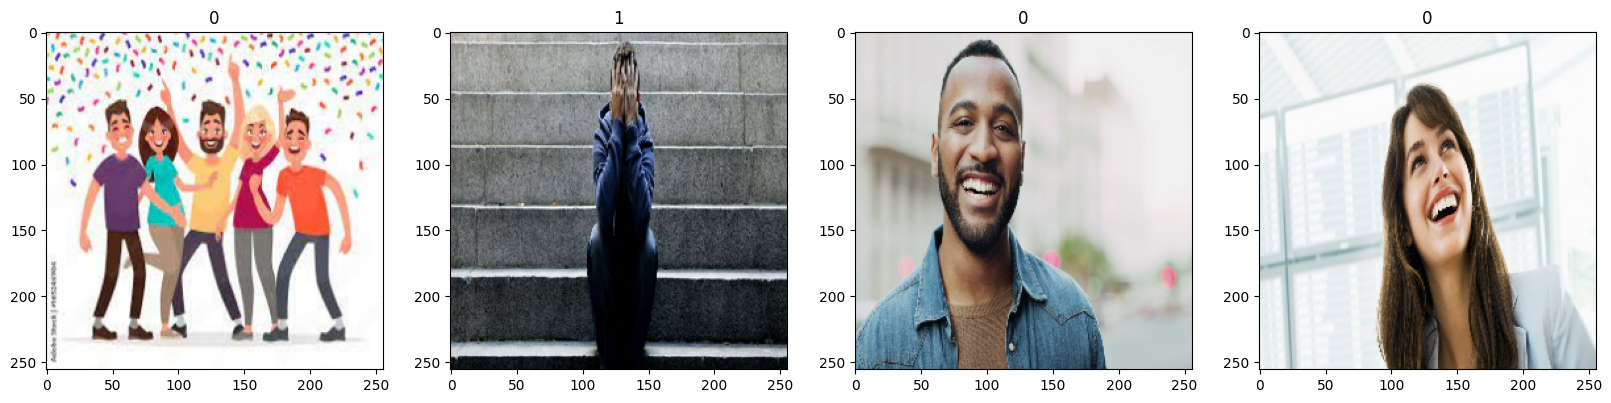

In [19]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

 **Preprocess**

1.Scale data

In [20]:
data=data.map(lambda x,y:(x/255,y))

In [21]:
scaled_iterator=data.as_numpy_iterator()

In [22]:
batch=scaled_iterator.next()

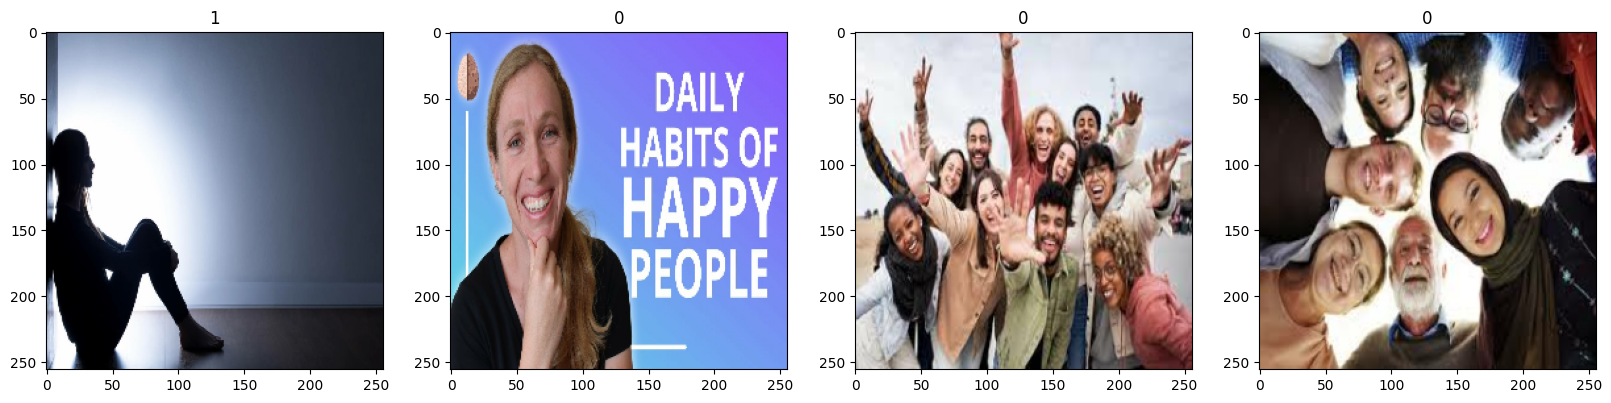

In [23]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.Split Data

In [24]:
len(data)

6

In [25]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)+1

In [26]:
train_size+val_size+test_size

6

In [27]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [28]:
len(train)

4

**Deep learning model**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

In [30]:
model=Sequential()

In [31]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

TRain the Model

In [34]:
logdir='logs'

In [35]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5437 - loss: 1.0994 - val_accuracy: 0.5312 - val_loss: 0.9568
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4531 - loss: 1.0093 - val_accuracy: 0.8125 - val_loss: 0.6487
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6427 - loss: 0.6556 - val_accuracy: 0.4375 - val_loss: 0.6893
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.6406 - loss: 0.6299 - val_accuracy: 0.7812 - val_loss: 0.5350
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7385 - loss: 0.4986 - val_accuracy: 0.7500 - val_loss: 0.5163
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7604 - loss: 0.4737 - val_accuracy: 0.8438 - val_loss: 0.3896
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8313 - loss: 0.4427 - val_accuracy: 0.7500 - val_loss: 0.4272
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8104 - loss: 0.4146 - val_accuracy: 0.9375 - val_loss: 0.2941
Epoch 9/

In [37]:
hist.history

{'accuracy': [0.5234375,
  0.421875,
  0.5859375,
  0.7109375,
  0.75,
  0.78125,
  0.8359375,
  0.859375,
  0.90625,
  0.9296875,
  0.9140625,
  0.9609375,
  0.984375,
  0.96875,
  0.9921875,
  0.9921875,
  0.9921875,
  1.0,
  1.0,
  1.0],
 'loss': [1.359647512435913,
  0.9489575028419495,
  0.6564649939537048,
  0.6136751174926758,
  0.5012412667274475,
  0.4495023488998413,
  0.42905640602111816,
  0.3840869069099426,
  0.3551485240459442,
  0.2449730783700943,
  0.2087007462978363,
  0.1460466831922531,
  0.11589601635932922,
  0.09305185824632645,
  0.07310539484024048,
  0.06463821977376938,
  0.0490780770778656,
  0.04318612813949585,
  0.02237008884549141,
  0.019484058022499084],
 'val_accuracy': [0.53125,
  0.8125,
  0.4375,
  0.78125,
  0.75,
  0.84375,
  0.75,
  0.9375,
  0.90625,
  0.90625,
  0.96875,
  0.9375,
  0.96875,
  0.96875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.9567891359329224,
  0.6487487554550171,
  0.6892635226249695,
  0.5349918603897095,

Plot the perfomance

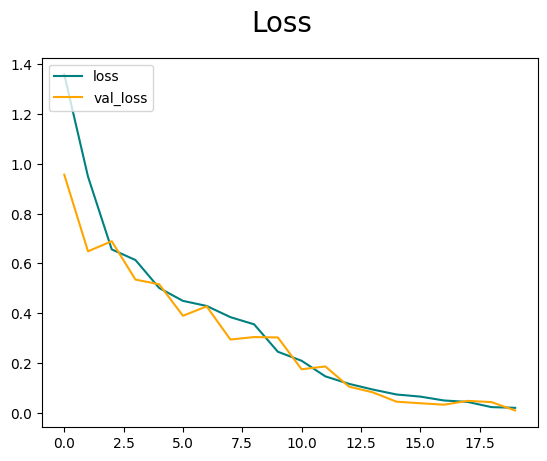

In [38]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

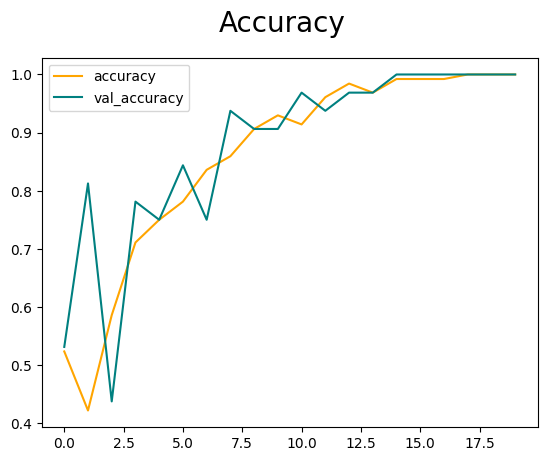

In [44]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='orange',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='teal',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

Evaluate the model

In [46]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [47]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat=model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [50]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:1.0,Accuracy:1.0
